In [10]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [11]:
with open("fb-pages-food.edges",encoding="utf8") as f:
    fb_links = f.read().splitlines() 
    #it tells us about the which edges connected

In [3]:
len(fb_links)  #no of edges


2102

In [12]:
node_list_1 = []
node_list_2 = []
#here we put connected nodes in different lists
for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
#data frame is just managing data  just giving column a name 

100%|██████████████████████████████████████████████████████████████████████████| 2102/2102 [00:00<00:00, 525788.82it/s]


In [13]:
fb_df.head()
# just checking if data frame is correctly constructed 

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


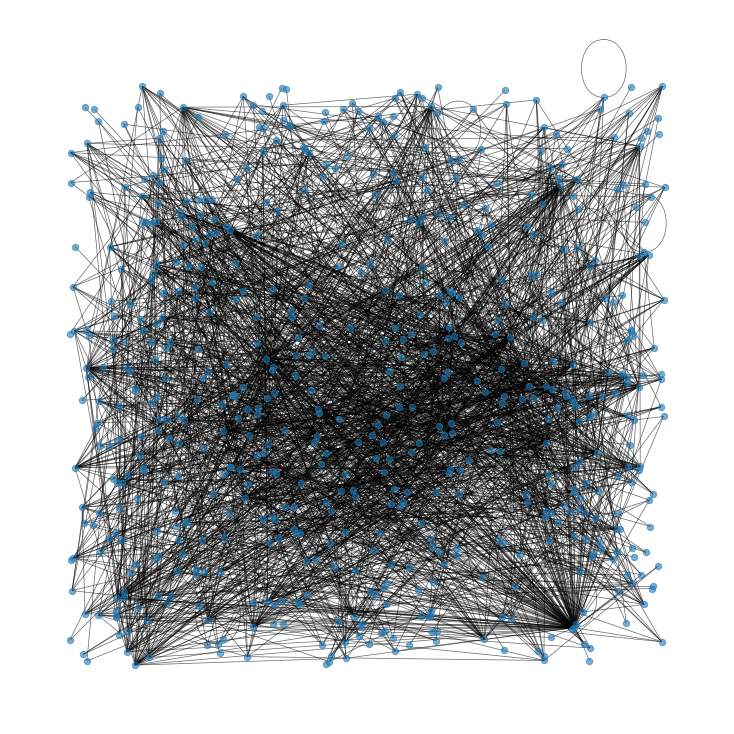

In [14]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [15]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [16]:
#shape of adjacency matrix
adj_G.shape


(620, 620)

In [17]:
# get unconnected node-pairs
all_unconnected_pairs = []

offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [00:08<00:00, 71.42it/s]


In [18]:
len(all_unconnected_pairs)

19018

In [19]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [20]:
#ommisable links those linked which can we removed 

initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

#find all ommisable links
for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|█████████████████████████████████████████████████████████████████████████████| 2102/2102 [00:08<00:00, 255.79it/s]


In [21]:
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15732\3498851448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)


In [22]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

In [23]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [24]:
!pip install node2vec

In [25]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.98it/s]


In [26]:
#x is storing the feature of each pair in a graph 
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.4, 
                                                random_state = 35)

In [28]:

lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [29]:
predictions = lr.predict_proba(xtest)

In [30]:
roc_auc_score(ytest, predictions[:,1])

0.8051360008408923

In [31]:
pip install  catboost

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [33]:
from catboost import CatBoostClassifier

In [34]:
cat = CatBoostClassifier(iterations=100, learning_rate=0.1, random_seed=42)

In [35]:
cat.fit(xtrain, ytrain)

0:	learn: 0.5880951	total: 189ms	remaining: 18.7s
1:	learn: 0.5088857	total: 212ms	remaining: 10.4s
2:	learn: 0.4479611	total: 239ms	remaining: 7.72s
3:	learn: 0.4027899	total: 265ms	remaining: 6.37s
4:	learn: 0.3675410	total: 289ms	remaining: 5.5s
5:	learn: 0.3405220	total: 314ms	remaining: 4.92s
6:	learn: 0.3188944	total: 340ms	remaining: 4.52s
7:	learn: 0.3019423	total: 364ms	remaining: 4.18s
8:	learn: 0.2882051	total: 395ms	remaining: 3.99s
9:	learn: 0.2763678	total: 418ms	remaining: 3.76s
10:	learn: 0.2687424	total: 441ms	remaining: 3.57s
11:	learn: 0.2606362	total: 464ms	remaining: 3.4s
12:	learn: 0.2538811	total: 492ms	remaining: 3.29s
13:	learn: 0.2485159	total: 521ms	remaining: 3.2s
14:	learn: 0.2436980	total: 544ms	remaining: 3.08s
15:	learn: 0.2397521	total: 568ms	remaining: 2.98s
16:	learn: 0.2366780	total: 590ms	remaining: 2.88s
17:	learn: 0.2331926	total: 617ms	remaining: 2.81s
18:	learn: 0.2304268	total: 645ms	remaining: 2.75s
19:	learn: 0.2275004	total: 669ms	remaining:

In [38]:
cat_pred = cat.predict(xtest) 

In [39]:
cat_accuracy = (cat_pred == ytest).mean()

In [40]:
print(f"CatBoost accuracy: {cat_accuracy:.4f}")

CatBoost accuracy: 0.9385


In [41]:
#from xgboost accuracy calculation
from xgboost import XGBClassifier

In [43]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [44]:
xgb.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [45]:
xgb_pred = xgb.predict(xtest)

In [46]:
xgb_accuracy = (xgb_pred == ytest).mean()

In [47]:
print(f"XGBoost accuracy: {xgb_accuracy:.4f}")

XGBoost accuracy: 0.9454


In [52]:
from sklearn.metrics import precision_score,recall_score

In [53]:
precision_cat = precision_score(ytest, cat_pred) 

In [54]:
recall_cat = recall_score(ytest, cat_pred) 

In [56]:
print(precision_cat)

0.743801652892562


In [57]:
print(recall_cat)

0.15985790408525755


In [58]:
precision_xgb = precision_score(ytest, xgb_pred) 

In [60]:
 recall_xgb = recall_score(ytest, xgb_pred) 

In [61]:
print(precision_xgb)

0.7169811320754716


In [62]:
print(recall_xgb)

0.33747779751332146


In [29]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [30]:
from pyvis.network import Network
net=Network(notebook=True,width="1000px",height="700px",bgcolor='#222222',font_color='white')
node_degree=dict(G.degree)
nx.set_node_attributes(G,node_degree, 'size')
net.from_nx(G)

net.show("facebook.html")

facebook.html


In [28]:
pip install python-louvain


Note: you may need to restart the kernel to use updated packages.


In [29]:
import community as community_louvain

In [30]:
communities=community_louvain.best_partition(G)

In [31]:
nx.set_node_attributes(G,communities,'group')

In [31]:
com_net=Network(notebook=True, width="1000px",height="700px",bgcolor='#222222',font_color="white")
com_net.from_nx(G)
com_net.show("community.html")

community.html


In [33]:
e = list(G.edges())
print(e)

[('0', '276'), ('0', '58'), ('0', '132'), ('0', '603'), ('0', '398'), ('0', '555'), ('276', '113'), ('276', '149'), ('276', '276'), ('276', '296'), ('276', '619'), ('276', '494'), ('276', '398'), ('276', '598'), ('276', '555'), ('58', '23'), ('58', '35'), ('58', '89'), ('58', '90'), ('58', '265'), ('58', '601'), ('58', '434'), ('58', '537'), ('58', '350'), ('58', '603'), ('58', '611'), ('58', '616'), ('58', '302'), ('58', '87'), ('132', '198'), ('603', '56'), ('603', '67'), ('603', '68'), ('603', '90'), ('603', '157'), ('603', '182'), ('603', '198'), ('603', '217'), ('603', '238'), ('603', '151'), ('603', '271'), ('603', '317'), ('603', '361'), ('603', '340'), ('603', '350'), ('603', '355'), ('603', '372'), ('603', '39'), ('603', '446'), ('603', '558'), ('603', '576'), ('603', '584'), ('603', '597'), ('603', '601'), ('603', '616'), ('398', '113'), ('398', '194'), ('398', '319'), ('398', '365'), ('398', '522'), ('398', '598'), ('398', '555'), ('555', '113'), ('555', '149'), ('555', '202

In [34]:
def triadic(e):
  new_edges = []
  
  for i in e:
    a, b = i
  
    for j in e:
      x, y = j
  
      if i != j:
        if a == x and (b, y) not in e and (y, b) not in e:
          new_edges.append((b, y))
        if a == y and (b, x) not in e and (x, b) not in e:
          new_edges.append((b, x))
        if b == x and (a, y) not in e and (y, a) not in e:
          new_edges.append((a, y))
        if b == y and (a, x) not in e and (x, a) not in e:
          new_edges.append((a, x))
  
  return new_edges
  
print("The possible new edges according to Triadic closure are :")
print(triadic(e))

The possible new edges according to Triadic closure are :
[('276', '58'), ('276', '132'), ('276', '603'), ('0', '113'), ('0', '149'), ('0', '296'), ('0', '619'), ('0', '494'), ('0', '598'), ('58', '276'), ('58', '132'), ('58', '398'), ('58', '555'), ('0', '23'), ('0', '35'), ('0', '89'), ('0', '90'), ('0', '265'), ('0', '601'), ('0', '434'), ('0', '537'), ('0', '350'), ('0', '611'), ('0', '616'), ('0', '302'), ('0', '87'), ('132', '276'), ('132', '58'), ('132', '603'), ('132', '398'), ('132', '555'), ('0', '198'), ('603', '276'), ('603', '132'), ('603', '398'), ('603', '555'), ('0', '56'), ('0', '67'), ('0', '68'), ('0', '90'), ('0', '157'), ('0', '182'), ('0', '198'), ('0', '217'), ('0', '238'), ('0', '151'), ('0', '271'), ('0', '317'), ('0', '361'), ('0', '340'), ('0', '350'), ('0', '355'), ('0', '372'), ('0', '39'), ('0', '446'), ('0', '558'), ('0', '576'), ('0', '584'), ('0', '597'), ('0', '601'), ('0', '616'), ('398', '58'), ('398', '132'), ('398', '603'), ('0', '113'), ('0', '194

In [35]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [36]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

In [83]:
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.2,#this is used for column sampling
    'bagging_fraction': 0.5,#used for row sampling 
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 80,
    'boosting':'gbdt'
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50)

C:\Users\DELL\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 920, number of negative: 11380
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 12300, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074797 -> initscore=-2.515239
[LightGBM] [Info] Start training from score -2.515239
[1]	valid_0's auc: 0.724871
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.76868
[3]	valid_0's auc: 0.786278
[4]	valid_0's auc: 0.800533
[5]	valid_0's auc: 0.814273
[6]	valid_0's auc: 0.825709
[7]	valid_0's auc: 0.832969
[8]	valid_0's auc: 0.837049
[9]	valid_0's auc: 0.84175
[10]	valid_0's auc: 0.847147
[11]	valid_0's auc: 0.853585
[12]	valid_0's auc: 0.854403
[13]	valid_0's auc: 0.858183
[14]	valid_0

[275]	valid_0's auc: 0.933037
[276]	valid_0's auc: 0.932922
[277]	valid_0's auc: 0.933136
[278]	valid_0's auc: 0.932868
[279]	valid_0's auc: 0.93291
[280]	valid_0's auc: 0.932933
[281]	valid_0's auc: 0.932538
[282]	valid_0's auc: 0.932845
[283]	valid_0's auc: 0.933043
[284]	valid_0's auc: 0.933212
[285]	valid_0's auc: 0.933235
[286]	valid_0's auc: 0.933414
[287]	valid_0's auc: 0.933526
[288]	valid_0's auc: 0.933573
[289]	valid_0's auc: 0.933644
[290]	valid_0's auc: 0.933698
[291]	valid_0's auc: 0.933386
[292]	valid_0's auc: 0.933262
[293]	valid_0's auc: 0.93354
[294]	valid_0's auc: 0.933597
[295]	valid_0's auc: 0.933457
[296]	valid_0's auc: 0.933392
[297]	valid_0's auc: 0.933454
[298]	valid_0's auc: 0.933233
[299]	valid_0's auc: 0.933222
[300]	valid_0's auc: 0.933185
[301]	valid_0's auc: 0.933165
[302]	valid_0's auc: 0.933422
[303]	valid_0's auc: 0.933573
[304]	valid_0's auc: 0.933596
[305]	valid_0's auc: 0.933625
[306]	valid_0's auc: 0.933758
[307]	valid_0's auc: 0.933609
[308]	valid_

In [84]:
y_train_pred= model.predict(xtrain)

roc_auc_score(ytrain, y_train_pred)

0.9999740200198671

In [85]:
y_valid_pred =model.predict(xtest)

roc_auc_score(ytest, y_valid_pred)

0.9343592405365897

In [77]:
 #this is change from fuzyy to binary sets so that we can use evaluation matrix 

In [78]:
y_boolean=y_valid_pred.round()

In [79]:
from sklearn.metrics import precision_score, recall_score

In [80]:
precision_lightgbm = precision_score(ytest, y_boolean)

In [81]:
recall_lightgbm = recall_score(ytest, y_boolean)

In [82]:
print(precision_lightgbm)

0.6607142857142857


In [76]:
print(recall_lightgbm)

0.5257548845470693
